In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [93]:
from pathlib import Path
from skimage.io import imshow
import matplotlib.pyplot as plt
from tqdm import tqdm

from torchvision.transforms import ToTensor, RandomCrop, Resize

from leaf.dta import LeafDataset, GetPatches, TransformPatches, test_greenness

In [3]:
train_dset = LeafDataset("./data/train_images", "./data/train_images/labels.csv")
val_dset = LeafDataset("./data/val_images", "./data/val_images/labels.csv")

In [4]:
img = train_dset[0][0]

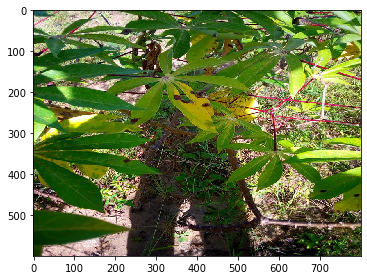

In [5]:
imshow(img)

In [36]:
random_green = RandomGreen(64, 64, green_ratio=0.7)

In [37]:
nongreen_imgs = []
green_imgs = []

In [38]:
for i in tqdm(range(1000)):
    random_green(ToTensor()(img))

100%|██████████| 1000/1000 [00:01<00:00, 653.45it/s]


In [39]:
len(green_imgs)

1000

In [40]:
len(nongreen_imgs)

50

In [7]:
def test_greenness(img, green_tol=0.1, ratio = 0.5):
    green_mod = (img[1, :, :] + green_tol).reshape(-1)
    n_pixels = len(green_mod)
    #import pdb; pdb.set_trace()
    return ((green_mod > img[0, :, :].reshape(-1)) & (green_mod > img[2, :, :].reshape(-1))).sum() / n_pixels > ratio

In [52]:
test_greenness(green_imgs[0])

tensor(True)

In [56]:
import random

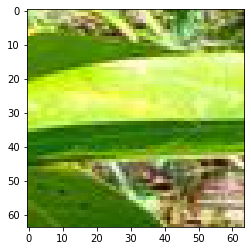

In [90]:
idx = random.randint(0, 999)
plt.imshow(green_imgs[idx].numpy().transpose([1, 2, 0]))

In [8]:
class RandomGreen(object):
    def __init__(self, size_x, size_y, green_tol=0.1, green_ratio=0.5):
        self.size_x = size_x
        self.size_y = size_y
        self.green_tol = green_tol
        self.green_ratio = green_ratio
        self.random_crop = RandomCrop(size=(size_x, size_y), pad_if_needed=True, fill=-1)

    def __call__(self, img):
        cand = self.random_crop(img)
        while(not ((cand > -1).all() & test_greenness(cand, self.green_tol, self.green_ratio))):
            nongreen_imgs.append(cand)
            cand = self.random_crop(img)
        green_imgs.append(cand)
        return cand

In [25]:
nongreen_imgs

[]

In [95]:
img = Resize((768, 576))(ToTensor()(img))

In [124]:
get_patches = GetPatches(768, 576, 12, 9)

In [125]:
patches = get_patches(img)

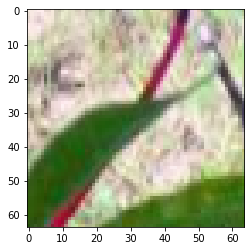

In [130]:
plt.imshow(patches[1].numpy().transpose([1, 2, 0]))

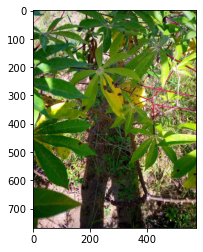

In [132]:
plt.imshow(img.numpy().transpose([1, 2, 0]))

> <ipython-input-119-39806f8a857b>(20)__call__()
     18         for x in range(self.x_patches):
     19             for y in range(self.y_patches):
---> 20                 patch = sample[:, (x * self.patch_width):((x + 1) * self.patch_width), (y * self.patch_height):((y + 1) * self.patch_height)]
     21                 patches.append(patch)
     22         return patches



ipdb>  x


0


ipdb>  y


0


ipdb>  sample.shape


torch.Size([3, 768, 576])


ipdb>  (x * self.patch_width)


0.0


ipdb>  x


0


ipdb>  self.patch_width


64.0


ipdb>  q


In [109]:
import torch

In [112]:
torch.tensor([1, 2]).shape

torch.Size([2])

In [114]:
tuple(Out[112])

(2,)

In [123]:
class GetPatches(object):
    def __init__(self, img_width, img_height, x_patches, y_patches):
        assert isinstance(img_width, (int, tuple))
        assert isinstance(img_height, (int, tuple))
        assert isinstance(x_patches, (int, tuple))
        assert isinstance(y_patches, (int, tuple))
        assert img_width % x_patches == 0 and img_height % y_patches == 0
        self.x_patches = x_patches
        self.y_patches = y_patches
        self.img_width = img_width
        self.img_height = img_height
        self.patch_width = int(img_width / x_patches)
        self.patch_height = int(img_height / y_patches)

    def __call__(self, sample):
        assert tuple(sample.shape[1:]) == (self.img_width, self.img_height)
        patches = []
        for x in range(self.x_patches):
            for y in range(self.y_patches):
                patch = sample[:, (x * self.patch_width):((x + 1) * self.patch_width), (y * self.patch_height):((y + 1) * self.patch_height)]
                patches.append(patch)
        return patches